In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bayes3d
import genjax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from src.model import model, viz_trace_meshcat
from src.utils import load_nice_intrinsics, get_nice_table_pose, load_pybullet_obs_img, load_some_object_meshes

In [3]:
console = genjax.console(enforce_checkify=True)

In [4]:
bayes3d.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


# Maximum Likelihood Estimation in Bayes3D

This notebook implements an inference algorithm for approximate maximum likelihood estimation of 3D scenes given a depth image of the scene.  This is done in the probabilistic model constructed in [01_tutorial-model.ipynb](01_tutorial-model.ipynb).

The inference library in GenJAX is still under development (as of 2024-02-09, the intention is for the next major GenJAX PR, in the next couple of weeks, to focus on providing more inference functionality).

As a result, this notebook uses fairly low-level Gen interfaces for modifying trace data structures to do MLE inference.

This can be extended to do posterior sampling; this can be done using the lower level interfaces used in this notebook, and it will especially be facilitated as higher-level interfaces for running algorithms like sequential Monte Carlo are added into GenJAX.

## Parsing a Pybullet tabletop scene (this one without stacking)

### Load in data to run inference on

In [5]:
# Load a raw image from a camera in pybullet,
# and a scaled down version we will perform inference on.
# (This is taken from the pybullet image format and preprocessed slightly
# into Bayes3D data structures, in `src.utils`.)
(img_fullres, img) = load_pybullet_obs_img()

Got rgbd_original
Got rgb immage scaled down.


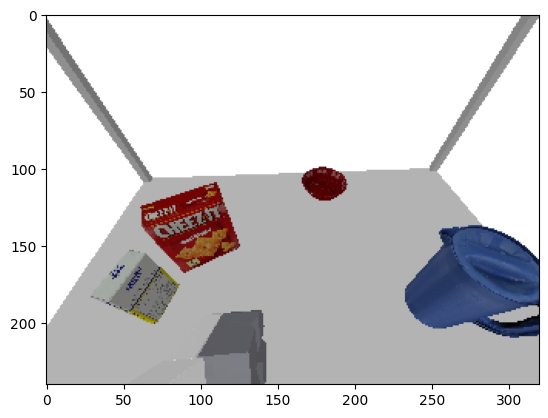

In [6]:
plt.imshow(bayes3d.get_rgb_image(img_fullres.rgb))

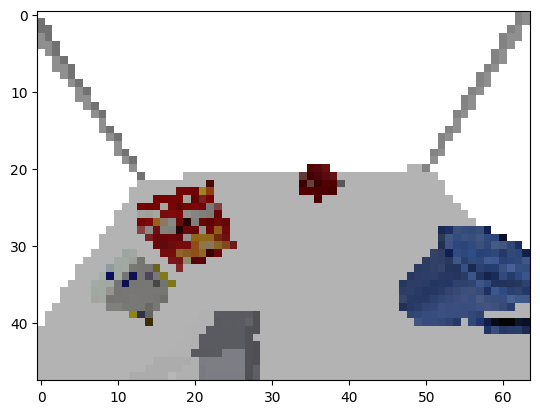

In [7]:
plt.imshow(bayes3d.get_rgb_image(img.rgb))

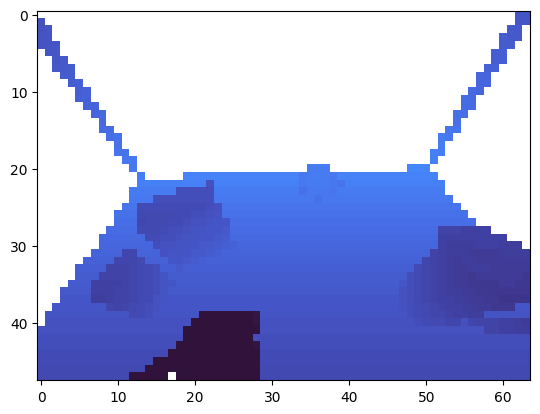

In [8]:
plt.imshow(bayes3d.get_depth_image(img.depth))

In [9]:
# The format of observed "images" in Bayes3D is not a WxH array of depth values,
# but instead is a WxHx3 array of 3D points in the camera frame.
# (Each pixel is the 3D point corresponding to the depth value at that pixel.)
obs_img_pointcloud = bayes3d.unproject_depth_jit(
        img.depth,
        img.intrinsics
    )
console.print(obs_img_pointcloud.shape)

(48, 64, 3)

### Set up the renderer and load in the object models for these

In [10]:
bayes3d.setup_renderer(img.intrinsics)

Increasing frame buffer size to (width, height, depth) = (64, 64, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [11]:
# I set up this function to load in all the YCB objects in this scene,
# plus a cuboid mesh for the table and the pillars at the edge of the enviornment.
# (It's easy to add in meshes from any mesh file.)
load_some_object_meshes()

Added table mesh.
Added pillar mesh.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000002.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000003.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000011.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000013.ply.
Added mesh at path /home/georgematheos/bayes3d/assets/bop/ycbv/models/obj_000021.ply.


['table',
 'pillar',
 '003_cracker_box',
 '004_sugar_box',
 '019_pitcher_base',
 '024_bowl',
 '061_foam_brick']

### Initialize a model trace with just the table

In [12]:
# Data shape wrangling util...don't worry about the details on your first pass.
def flat_choicemaps_to_vector_choicemap(choicemaps):
    cm = genjax.choice_map({
        k : jnp.array([c.get_submap(k).get_value() for c in choicemaps])
        for (k, _) in choicemaps[0].get_submaps_shallow()
    })
    return cm

First, we'll construct a Gen ChoiceMap for `generate_objects` which makes it generate the table in the scene as object 0.

Here, I tell Gen the pose of the table (it will not infer it).  (This can make sense in cases like tabletop robotics where we may know the table pose.  I think it would pretty easy to infer the table pose, using an importance sampling proposal distribution based on RANSAC.)

In [13]:
table_choicemap = genjax.choice_map({
        #    This function returns the table pose from this pybullet scene,
        #    which we will give to inference as a known value.
                    "root_pose": get_nice_table_pose(),
                    "category_index": 0,
                    "parent_obj": -1,
                    "face_parent": 2,
                    "face_child": 3,
                    "contact_params": jnp.zeros(3)
                })

Next, we construct a constraint choicemap for the whole scene.  This will be used to generate a model trace with:
1. 1 object.
2. A fixed identity camera pose.
3. The table object specified above.
4. The observed camera image.
5. A low variance in the image noise model.

We will also construct arguments for the model, and then generate a trace.

We will then run inference by iteratively updating the trace to add one new object to the scene at a time.

In [14]:
max_n_objects = 8
# Initialize the trace with the table, and all
# the other objects initialized to be on the table
# with the identity pose.
map_choicemap = genjax.indexed_choice_map(
            jnp.arange(1),
            flat_choicemaps_to_vector_choicemap([
                table_choicemap
            ])
        )
constraints = genjax.choice_map({
    "n_objects": 1,
    "camera_pose": jnp.eye(4),
    "image": obs_img_pointcloud,
    "objects": map_choicemap,
    "variance": 0.02
})
console.print(constraints)

(HierarchicalChoiceMap)
├── :n_objects
│   └── (ValueChoice)
│       └── (const) 1
├── :camera_pose
│   └── (ValueChoice)
│       └──  f32[4,4]
├── :image
│   └── (ValueChoice)
│       └──  f32[48,64,3]
├── :objects
│   └── (IndexedChoiceMap,  i32[1])
│       └── (HierarchicalChoiceMap)
│           ├── :root_pose
│           │   └── (ValueChoice)
│           │       └──  f32[1,4,4]
│           ├── :category_index
│           │   └── (ValueChoice)
│           │       └──  i32[1]
│           ├── :parent_obj
│           │   └── (ValueChoice)
│           │       └──  i32[1]
│           ├── :face_parent
│           │   └── (ValueChoice)
│           │       └──  i32[1]
│           ├── :face_child
│           │   └── (ValueChoice)
│           │       └──  i32[1]
│           └── :contact_params
│               └── (ValueChoice)
│                   └──  f32[1,3]
└── :variance
    └── (ValueChoice)
        └── (const) 0.02

In [15]:
model_args = (
    jnp.arange(max_n_objects), # max_n_objects_array
    # possible_object_indices
    jnp.arange(len(bayes3d.RENDERER.meshes)),
    # pose_bounds
    jnp.array([-jnp.ones(3)*5.0, jnp.ones(3)*5.0]),
    # contact_bounds
    jnp.array([jnp.array([-1., -1., -jnp.pi]), jnp.array([1., 1., jnp.pi])]),
    # all_box_dims
    bayes3d.RENDERER.model_box_dims
)

In [16]:
key = jax.random.PRNGKey(6)
tr1, _ = model.importance(key, constraints, model_args)
viz_trace_meshcat(tr1)

The call to `viz_trace_meshcat` produced a visualization of the trace generated above.  Open the MeshCat visualizer to see it!

The visualization shows
- The table object mesh
- The point cloud (in red) of what the scene with just the table would look like
- The observed point cloud (in black) (which also contains objects in addition to the table, yet to be added to the latent state of the trace)

### Add an object to the scene

In [17]:
# Get a choicemap for `generate_object` which
# adds an object with category `category_idx` to the scene,
# on the table (parent_obj=0), with its bottom (face_child=3)
# on the table's top (face_parent=2).
# Initialize at the center of the table (contact_params=0).
def obj_choicemap(category_idx):
    return genjax.choice_map({
        "category_index": category_idx,
        "parent_obj": 0,
        "face_parent": 2,
        "face_child": 3,
        "contact_params": jnp.zeros(3)
    })

# Get a choicemap for `model` which adds an object with category `category_idx`
# to the scene.
# (This requires incrementing the `n_objects` choice in the model,
# and adding the new object to the `objects` choice.)
def add_object_choicemap(prev_n_objects, cat_idx):
    obj_idx = prev_n_objects
    return genjax.choice_map({
        "n_objects": prev_n_objects + 1,
        "objects": genjax.indexed_choice_map(
            jnp.array([obj_idx]),
            flat_choicemaps_to_vector_choicemap([obj_choicemap(cat_idx)])
        )
    })

# Update `tr` using Gen's `Trace.update`.
def add_object(tr, cat_idx):
    n_objects = tr["n_objects"]
    newtr, _, _, _ = tr.update(
        key,
        add_object_choicemap(n_objects, cat_idx)
    )
    return newtr

Add an object and visualize the resulting scene in meshcat:

In [18]:
example_tr2 = add_object(tr1, 3)
viz_trace_meshcat(example_tr2)

Here's what the depth image of this scene would look like without noise:

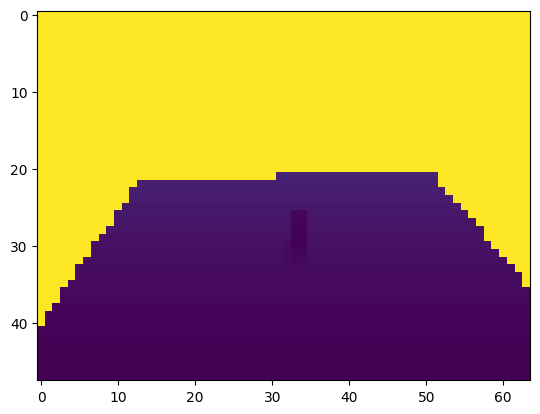

In [19]:
plt.imshow(example_tr2.get_retval().rendered[:, :, 2])

### Implementing the MLE single-object inference algorithm: Coarse-to-Fine grid enumeration over object contact parameters

In [20]:
# Construct a choicemap for `model`
# telling Gen to set the object at index `object_idx`
# to having contact parameters (x, y, theta)
# relative to its parent object in the scene graph.
def cp_choicemap(object_idx, v):
    return genjax.choice_map({
            "objects": genjax.indexed_choice_map(
                jnp.array([object_idx]),
                flat_choicemaps_to_vector_choicemap([
                    genjax.choice_map({"contact_params": v})
                ])
            )
        })

In [21]:
console.print(
    cp_choicemap(1, jnp.array([0.1, -0.32, jnp.pi * 1/4]))
)

(HierarchicalChoiceMap)
└── :objects
    └── (IndexedChoiceMap,  i32[1])
        └── (HierarchicalChoiceMap)
            └── :contact_params
                └── (ValueChoice)
                    └──  f32[1,3]

Now let's implement the coarse-to-fine enumeration infernece algorithm. The algorithm details are explained in the comments in the code.

In [22]:
# Sequence of gridding schedules, saying
# (1) the total range of the grid over x and y values
# (2) the total range of the grid over the angle values
# (3) the number of grid points along each dimension
grid_params = [
    (0.65, jnp.pi, (30,30,15)),
    (0.2, jnp.pi, (15,15,15)),
    (0.1, jnp.pi, (15,15,15)),
    (0.05, jnp.pi, (15,15,15)),
    (0.02, jnp.pi, (9,9,51)),
    (0.01, jnp.pi/5, (15, 15, 15))
]

# Sequence of grids, represented as a list of
# arrays of shape (n,3), where n is the number of grid points
# and the second axis is the x, y, and angle value for the grid point.
contact_param_gridding_schedule = [
    bayes3d.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

# This function attempts to find the contact parameters of the object
# at index `object_index` with its parent object in the scene graph
# which maximize the likelihood of the observed image.
# This is done through coarse-to-fine grid enumeration.
def _c2f(key, tr, object_idx, contact_param_gridding_schedule):
    # Get the likelihood of the trace, with the `object_idx`-th
    # object's contact parameters set to `cp`.
    # (`cp` stands for "contact parameters" and has the form
    #   (x, y, theta).)
    def score_single_cp(trace, cp):
        updated_trace, _, _, _ = trace.update(
            key, cp_choicemap(object_idx, cp)
        )
        # Get the score of the `image` (since we're doing
        # MLE inference, and want to look at the likelihood).
        return updated_trace.project(genjax.select("image"))

    # `vmap` over `score_single_cp`, with in_axes=(None, 0),
    # to get a function that takes
    # in 
    # an Nx3 array of contact parameters and returns an N-length
    # array of scores.
    scorer = jax.vmap(score_single_cp, in_axes=(None, 0))
    
    # This line slightly improves compilation times and could be skipped;
    # it's not important to understand...
    scorer = jax.jit(scorer)

    # Center the grids at the current contact parameters of the object.
    cp = tr.get_retval().object_info.params[object_idx, ...]

    # For each grid in the schedule, get the image likelihood for each
    # contact parameter assignment in the grid,
    # and then update the value `cp` to the one which maximizes
    # the image likelihood at this grid level.
    # Then descend to the next grid level, centered at the new `cp`
    # (but with a smaller range of values, so that we gradually
    # hone in on the exactly right value).
    for cp_grid in contact_param_gridding_schedule:
        cps = cp + cp_grid
        scores = scorer(tr, cps)
        cp = cps[jnp.argmax(scores)]
    potential_trace = tr.update(key, cp_choicemap(object_idx, cp))[0]
    return potential_trace

# c2f does the exact same thing as _c2f, but the first time
# it runs this, it compiles the function to run on GPU.
# Each subsequent time it will run much faster since it will just
# call the cached compiled version.
c2f = jax.jit(_c2f)

Here's a wrapper on c2f which first adds an object to the scene using `add_object`:

In [23]:
def _extend_then_c2f(key, tr, cat_idx, contact_param_gridding_schedule):
    return c2f(
        key,
        add_object(tr, cat_idx),
        tr["n_objects"],
        contact_param_gridding_schedule
    )
extend_then_c2f = jax.jit(_extend_then_c2f)

Let's add a cracker box to the scene, and see where C2F puts it:

In [24]:
tr_with_crackerbox = extend_then_c2f(key, tr1, 2, contact_param_gridding_schedule)
viz_trace_meshcat(tr_with_crackerbox)

Nice!

### Full MLE inference algorithm

First we add a wrapper to `c2f` which tries adding an object of each category and fitting it using c2f, and keeping whichever one has the highest likelihood.

Then we add a loop to the inference algorithm which iteratively adds objects to the scene and fits them using the coarse-to-fine algorithm, until this stops significantly improving the image likelihood.

In [25]:
def extend_c2f_all_categories(key, tr, contact_param_gridding_schedule):
    indices = jnp.arange(len(bayes3d.RENDERER.meshes))
    keys = jax.random.split(key, len(indices))
    potential_trs = [extend_then_c2f(key, tr, idx, contact_param_gridding_schedule) for (key, idx) in zip(keys, indices)]
    scores = jnp.array([t.project(genjax.select("image")) for t in potential_trs])
    best_idx = jnp.argmax(scores)
    return potential_trs[best_idx]

Add one object of the category which most increases likelihood:

In [26]:
tr_anyobj = extend_c2f_all_categories(key, tr1, contact_param_gridding_schedule)
viz_trace_meshcat(tr_anyobj)

Depth image of scene with added object:

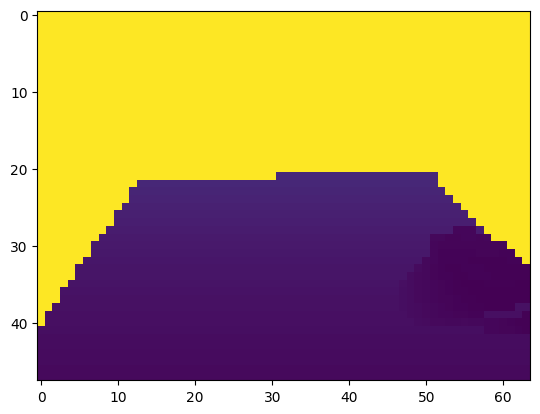

In [27]:
plt.imshow(tr_anyobj.get_retval().rendered[:, :, 2])

Observed depth image:

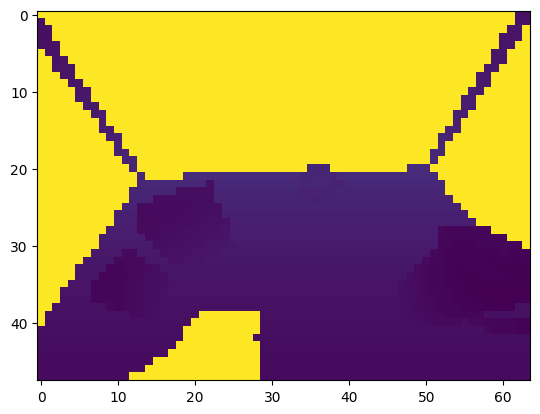

In [28]:
plt.imshow(tr_anyobj["image"][:, :, 2])

You can see that this adds the pitcher to the scene, which explains the most unexplained points.

Now, let's keep adding objects until the likelihood stops improving.

In [29]:
def fit_objects_until_convergence(key, tr, contact_param_gridding_schedule, eps=0.1, max_iter=10):
    old_score = -jnp.inf
    new_score = tr.project(genjax.select("image"))
    i = 1
    print("Adding first object...")
    while new_score > old_score + eps and i < max_iter:
        newtr = extend_c2f_all_categories(key, tr, contact_param_gridding_schedule)
        old_score = new_score
        new_score = newtr.project(genjax.select("image"))
        if new_score > old_score + eps:
            tr = newtr
        print(f"Added object {i}.  Image score = {new_score}.")
        i += 1
    return tr

In [ ]:
# Run once to compile
import time
start = time.time()
fit_objects_until_convergence(key, tr1, contact_param_gridding_schedule)
end = time.time()
print(f"Time to fit objects (compilation run): {end - start} seconds.")

In [30]:
# Subsequent runs are fast
start = time.time()
tr_fully_fit = fit_objects_until_convergence(key, tr1, contact_param_gridding_schedule)
end = time.time()
print(f"Time to fit objects (once compiled): {end - start} seconds.")

viz_trace_meshcat(tr_fully_fit)

Adding first object...
Added object 1.  Image score = 42.366539001464844.
Added object 2.  Image score = 43.408203125.
Added object 3.  Image score = 44.10807418823242.
Added object 4.  Image score = 44.661460876464844.
Added object 5.  Image score = 45.263671875.
Added object 6.  Image score = 45.41015625.
Added object 7.  Image score = 45.5078125.


Depth image of inferred scene:

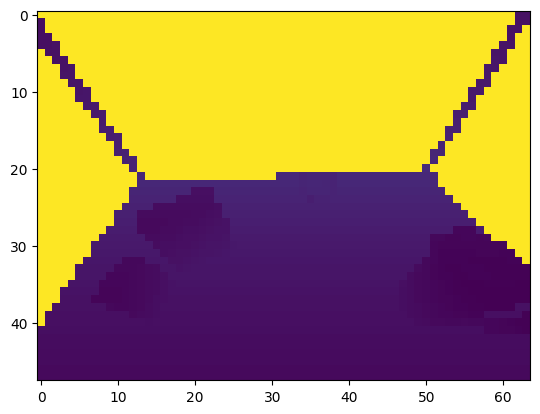

In [31]:
plt.imshow(tr_fully_fit.get_retval().rendered[:, :, 2])

You can see that (modulo the poor pyplot visualization -- you should really look at the meshcat! --) the inferred scene is a great match to the observed scene.

## Inferring a scene graph of stacked cubes

### Construct test scene of stacked cubes

First, let's add a few cube meshes to the renderer:

In [32]:
n_meshes_precubes = len(bayes3d.RENDERER.meshes)

CUBE_SIZES = [0.05, 0.15, 0.25]
cube_mesh_indices = [n_meshes_precubes + i for i in range(len(CUBE_SIZES))]
for size in CUBE_SIZES:
    cube_mesh = bayes3d.utils.make_cuboid_mesh(size * jnp.ones(3))
    bayes3d.RENDERER.add_mesh(cube_mesh, "cube_{}".format(size))
    print(f"Added cube mesh of size {size}.")

Added cube mesh of size 0.05.
Added cube mesh of size 0.15.
Added cube mesh of size 0.25.


Now, construct a choicemap specifying the scene of stacked cubes we'll run inference on.

In [58]:
def cube_obj_choicemap(category_idx, parent_idx, cps):
    return genjax.choice_map({
        "root_pose": jnp.eye(4),
        "category_index": category_idx,
        "parent_obj": parent_idx,
        "face_parent": 2,
        "face_child": 3,
        "contact_params": cps
    })

cube_scene_constraints = genjax.choice_map({
    "n_objects": 4,
    "camera_pose": jnp.eye(4),
    "objects": genjax.indexed_choice_map(
            jnp.arange(4),
            flat_choicemaps_to_vector_choicemap([
                table_choicemap,
                *[cube_obj_choicemap(ci, pi, cps) for (ci, pi, cps) in [
                    (cube_mesh_indices[1], 0, jnp.array([-0.1, 0.17, jnp.pi * 0.7])),
                    (cube_mesh_indices[0], 1, jnp.array([0.03, 0.012, -jnp.pi * 0.34])),
                    (cube_mesh_indices[2], 0, jnp.array([0.2, -0.4, jnp.pi * 0.11])),
                ]]
            ])
        ),
    "variance": 0.02,
})

In [59]:
model_args_cubes = (
    jnp.arange(8), # max_n_objects_array
    # possible_object_indices
    jnp.array(cube_mesh_indices), # only consider objects among the cubes
    # pose_bounds
    jnp.array([-jnp.ones(3)*5.0, jnp.ones(3)*5.0]),
    # contact_bounds
    jnp.array([jnp.array([-1., -1., -jnp.pi]), jnp.array([1., 1., jnp.pi])]),
    # all_box_dims
    bayes3d.RENDERER.model_box_dims
)

In [60]:
synthetic_cube_trace, _ = model.importance(key, cube_scene_constraints, model_args_cubes)
viz_trace_meshcat(synthetic_cube_trace)

In [61]:
obs_img_pointcloud_cubes = synthetic_cube_trace.get_retval().rendered

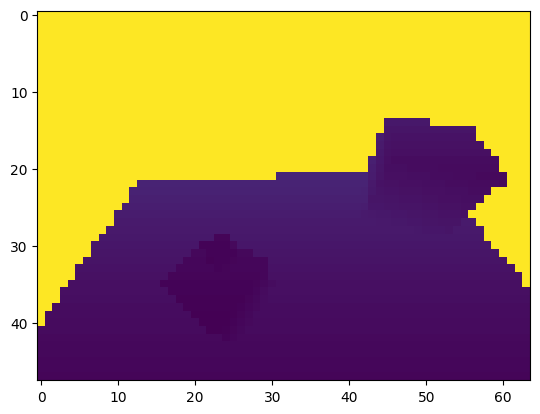

In [62]:
plt.imshow(obs_img_pointcloud_cubes[:, :, 2])

### Extend MLE inference algorithm to support scene graph inference

Now we're going to augment the inference algorithm so that in addition to adding objects flat on the table, the inference algorithm tries adding objects on top of the objects it has already placed.  This lets inference succeed in scenes with stacked objects.  Inference, if successful, will identify a likelihood-maximizing scene graph of the stacked objects.

Since objects are smaller than the table, we will enumerate a smaller grid when placing objects on top of other objects.  We first define that:

In [36]:
grid_params_narrow = [
    (0.15, jnp.pi, (15,15,15)),
    (0.08, jnp.pi, (15,15,15)),
    (0.04, jnp.pi, (15,15,15)),
    (0.02, jnp.pi, (9,9,51)),
    (0.01, jnp.pi/5, (15, 15, 15))
]

contact_param_gridding_schedule_narrow = [
    bayes3d.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params_narrow
]

Now we construct variants of `add_object` and `extend_then_c2f` from above, both of which assumed the object being added was on the table.  (Now we make the parent object be an argument to the variants of these functions.)

In [123]:
# Variant of `add_object` above which also lets us specify the parent of the object
# to add.
def add_object_with_parent(tr, cat_idx, parent_idx):
    prev_n_objects = tr["n_objects"]
    constraints = genjax.choice_map({
        "n_objects": prev_n_objects + 1,
        "objects": genjax.indexed_choice_map(
            jnp.array([prev_n_objects]),
            flat_choicemaps_to_vector_choicemap([
                 genjax.choice_map({
                    "root_pose": jnp.eye(4),
                    "category_index": cat_idx,
                    "parent_obj": parent_idx,
                    "face_parent": 2,
                    "face_child": 3,
                    "contact_params": jnp.zeros(3)
                })
            ])
        )
    })
    new_tr = tr.update(key, constraints)[0]
    return new_tr

In [124]:
# Same as `extend_then_c2f` from above, but the parent object isn't necessarily the table.
def _extend_then_c2f_with_parent(key, tr, cat_idx, parent_idx, contact_param_gridding_schedule):
    return c2f(
        key,
        add_object_with_parent(tr, cat_idx, parent_idx),
        tr["n_objects"],
        contact_param_gridding_schedule
    )
extend_then_c2f_with_parent = jax.jit(_extend_then_c2f_with_parent)

Now we implement a MLE function for fitting a single object somewhere in the scene graph, and after that, an MLE function for the whole scene graph, that keeps adding objects until convergence.

In [104]:
# Run c2f for all categories, and also trying to stack this new object
# on the table and also on top of every other object in the scene.
# Return the trace among these which maximizes the image likelihood.
def add_object_possibly_stacked(key, tr, possible_category_indices):
    n_objects = tr["n_objects"]

    trs_flat = [
        extend_then_c2f_with_parent(key, tr, cat, 0, contact_param_gridding_schedule)
        for cat in possible_category_indices
    ]
    trs_on_other_objects = []
    for i in range(1, n_objects):
        tr_ = [
            extend_then_c2f_with_parent(key, tr, cat, i, contact_param_gridding_schedule_narrow)
            for cat in possible_category_indices
        ]
        trs_on_other_objects.append(tr_)
    all_trs_flat = trs_flat + [t for ts in trs_on_other_objects for t in ts]
    scores = jnp.array([tr.project(genjax.select("image")) for tr in all_trs_flat])
    tr = all_trs_flat[jnp.argmax(scores)]
    return tr

In [133]:
def fit_scenegraph_until_convergence(
        key, tr,
        possible_category_indices, eps=0.1, max_iter=10
    ):
    old_score = -jnp.inf
    new_score = tr.project(genjax.select("image"))
    i = 1
    print("Adding first object...")
    while new_score > old_score + eps and i < max_iter:
        newtr = add_object_possibly_stacked(key, tr, possible_category_indices)
        old_score = new_score
        new_score = newtr.project(genjax.select("image"))
        if new_score > old_score + eps:
            tr = newtr
        print(f"Added object {i}.  Image score = {new_score}.")
        i += 1
    return tr

### Run scene graph inference on the test scene

Initialize an empty trace which doesn't know which objects are in the scene (except the table):

In [134]:
constraints_t1 = genjax.choice_map({
    "camera_pose": jnp.eye(4),
    "n_objects": 1,
    "objects": genjax.indexed_choice_map(
        jnp.arange(1),
        flat_choicemaps_to_vector_choicemap([table_choicemap])
    ),
    "variance": 0.02,
    "image": obs_img_pointcloud_cubes
})

inferred_cubes_tr_1, _ = model.importance(key, constraints_t1, model_args_cubes)
viz_trace_meshcat(inferred_cubes_tr_1)

In [139]:
# run this once just so it compiles...
start = time.time()
fit_scenegraph_until_convergence(
    key, inferred_cubes_tr_1, jnp.array(cube_mesh_indices)
)
end = time.time()
print(f"Run in {end - start} seconds during compilation.")

Adding first object...
Added object 1.  Image score = 47.900390625.
Added object 2.  Image score = 49.658203125.
Added object 3.  Image score = 49.90234375.
Added object 4.  Image score = 49.90234375.
Run in 2.2809038162231445 seconds.


Now if we run it again, it is fast

In [136]:
start = time.time()
inferred_scenegraph_trace = fit_scenegraph_until_convergence(
    key, inferred_cubes_tr_1, jnp.array(cube_mesh_indices)
)
end = time.time()
print(f"Run in {end - start} seconds (after compilation).")
viz_trace_meshcat(inferred_scenegraph_trace)

Adding first object...
Added object 1.  Image score = 47.900390625.
Added object 2.  Image score = 49.658203125.
Added object 3.  Image score = 49.90234375.
Added object 4.  Image score = 49.90234375.


Great! As the meshcat shows, we have successfully inferred the scene graph of these objects.

Here's the depth image rendering of the inferred trace -- looks just the same as the observation.

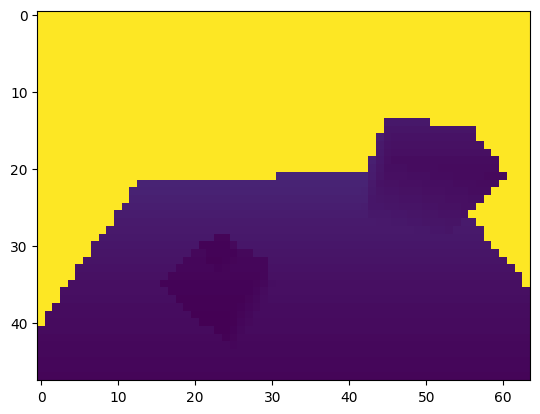

In [137]:
plt.imshow(inferred_scenegraph_trace.get_retval().rendered[:, :, 2])

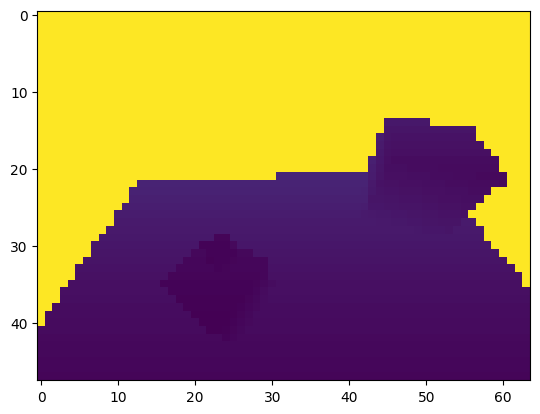

In [138]:
# For reference, here's the observed one:
plt.imshow(obs_img_pointcloud_cubes[:, :, 2])